<a href="https://colab.research.google.com/github/ShinAsakawa/bit/blob/main/notebooks/2022_0617bit_faster_rcnn_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
- date: 2022_0604 original file written at 2022_0319
- filename: 2022_0604bit_faster-rcnn_fine_tuning.ipynb
- ref source: https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook
---

**注**: workers=0 で動作するので時間がかかる

In [10]:
# Google Drive からデータを入手
# このセルを実行するとブラウザの別タブで Google アカウントへの認証が求められる
# Google アカウントを選択するとクリデンシャルキーが表示されるので，そのキーを
# コピーして，このセルの出力欄にある空欄に貼り付けてエンターキー (リターンキー) を押下する
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 以下実際のデータの情報
#https://drive.google.com/file/d/1xKXbovkEQwdJefzCuaS_a351LUIuRz-1/view?usp=sharing  for  cis.twcu.ac.jp/GitHub_shared/ccap_data.tgz on Gdrive
#https://drive.google.com/file/d/1PVwPXiBiRX4Aueqc3MHuosG5mWNnrvVa/view?usp=sharing  for 2022_0605fine_tuned_bit_line_bisection_pasiphae.cpt on Gdrive

file_id = '1xKXbovkEQwdJefzCuaS_a351LUIuRz-1'
file_id = '1PVwPXiBiRX4Aueqc3MHuosG5mWNnrvVa'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('2022_0605fine_tuned_bit_line_bisection_pasiphae.cpt')

In [12]:
#!ls -lh 2022_0605fine_tuned_bit_line_bisection_pasiphae.cpt

-rw-r--r-- 1 root root 475M Jun 16 20:28 2022_0605fine_tuned_bit_line_bisection_pasiphae.cpt


# faster-rcnn 転移学習または微調整を用いた BIT 線分 2 等分課題

[BIT] 図版を [Faster RCNN](https://arxiv.org/abs/1506.01497) で微調整して訓練

* Faster RCNNについては [Faster-RCNNの仕組みをより深く理解するために](https://medium.com/@whatdhack/a-deeper-look-how-faster-rcnn-works-84081284e1cd) の Media 参照。
* [Pytorch 公式チュートリアル文書](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) も参照

転移学習 transfer learning と微調整 fine tuning については，種々考え方がある。
だがここでは，[PyTorch のチュートリアル](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) に従って，
最終層だけ入れ替えて，最終直下層以下の結合係数を固定して考える場合を転移学習と呼ぶことにする。
全層を再学習することを，微調整と呼ぶことにする。
このチュートリアルが参照にしているのは，Karpathy の スタンフォードでの授業 [cs231n の転移学習のノート](https://cs231n.github.io/transfer-learning/) である。


# 1. インストールとインポート
<!-- ## Installs and Imports -->

## 1.1 下準備

必要なライブラリのインストールなど

In [ ]:
# 2022_0605 現在，下記の再インストールが必要のようだ
# また，訓練時に halt する
!pip install --upgrade albumentations
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

In [ ]:
import os
import sys
import shutil
import typing
import cv2
import glob
from tqdm.notebook import tqdm

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    from PIL import ImageFont
    from glob import glob

    !pip install pycocotools --quiet
    !git clone https://github.com/pytorch/vision.git
    !git checkout v0.3.0

    # Download TorchVision repo to use some files from references/detection
    # os.symlink(src,dst) にした方が良いかも
    !cp vision/references/detection/utils.py ./
    !cp vision/references/detection/transforms.py ./
    !cp vision/references/detection/coco_eval.py ./
    !cp vision/references/detection/engine.py ./
    !cp vision/references/detection/coco_utils.py ./
    
    !pip install japanize_matplotlib
    #!pip install albumentataions  # 2022_0604 一時的に中断 colab でエラー発生のため
    
    # 自作ライブラリ
    !git clone https://github.com/ShinAsakawa/bit.git

    # Noto fonts のダウンローAドとインストール
    !mkdir Noto_JP_fonts
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifJP.zip
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansJP.zip
    !unzip NotoSerifJP.zip -d Noto_JP_fonts
    !unzip -o NotoSansJP.zip -d Noto_JP_fonts  # `-o` means overwrite 
    !mv Noto_JP_fonts bit
    !mkdir data
    
    noto_font_dir = './bit/Noto_JP_fonts'
    notofonts_fnames = glob(os.path.join(noto_font_dir,'*otf'))
    notofonts = {fname.split('/')[-1].split('.')[0]:{'fname':fname} for fname in notofonts_fnames}
    for fontname in notofonts.keys():
        notofonts[fontname]['data'] = ImageFont.truetype(notofonts[fontname]['fname'])
else:
    # 自分のリポジトリからシンボリックリンクで代用
    for file in ['engine.py', 'utils.py', 'coco_utils.py', 'transforms.py', 'coco_eval.py']:
        if not os.path.exists(file):
            _file = os.path.join('../2020pytorch_vision.git/reference/detection/', file)
            !ln -s ../2020pytorch_vision.git/references/detection/engine.py .
            !ln -s ../2020pytorch_vision.git/references/detection/utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/transforms.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_eval.py .
            

# DETR のサンプルプログラムを借用
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS = COLORS * 100

## 1.2 ライブラリのインポート

In [15]:
# ライブラリのインポート
# python と機械学習のための基本ライブラリ
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import japanize_matplotlib

# torchvision ライブラリ
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# ヘルパライブラリをインポート
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [17]:
%load_ext autoreload
%autoreload 2
from bit import BIT

if isColab:
    bit = BIT(fontdata=notofonts)
else:
    bit = BIT()
images, bboxes = bit.make_line_bisection_task_images(N=1, n_lines=3)

import PIL
def plot_pilimg_and_bbox(pil_img:PIL.Image.Image, 
                         bboxes:list,
                         verbose:bool=False
                        ):
    """bounding box (物体を囲む四角形の境界領域のことを境界領域箱と呼ぶ): bbox
    PIL 画像を境界領域と共に表示する関数"""
    plt.figure(figsize=(10,8))
    plt.imshow(pil_img)
    ax = plt.gca()
    for (xmin, ymin, xmax, ymax), c in zip(bboxes, COLORS):
        if verbose:
            print(f'xmin:{xmin}, ymin:{ymin}')
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))    

In [24]:
from bit import BIT_LineBisection
train_dataset = BIT_LineBisection(_symbols=bit.symbols, dirname='bit/data/line_bisection/train')
test_dataset = BIT_LineBisection(_symbols=bit.symbols, dirname='bit/data/line_bisection/test')

In [ ]:
from bit import get_object_detection_model

num_classes = len(bit.symbols)
print(f'num_classes:{num_classes}, bit.symbols:{bit.symbols}')
model = get_object_detection_model(num_classes)

In [47]:
XXX = torch.load('2022_0605fine_tuned_bit_line_bisection_pasiphae.cpt')
model.load_state_dict(XXX['model'])
#help(model)

<All keys matched successfully>

In [48]:
def torch_to_pil(img):
    """torchtensor を PIL 画像に変換する関数
    function to convert a torchtensor back to PIL image"""
    return torchtrans.ToPILImage()(img).convert('RGB')

# 可能なら GPU 上で学習させる
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

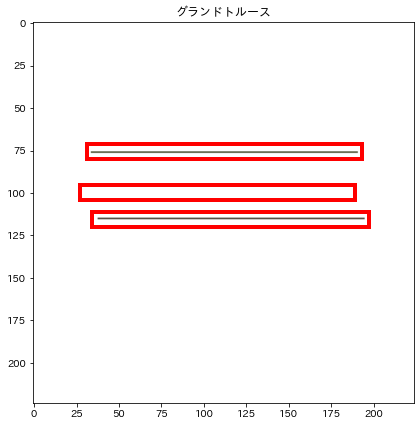

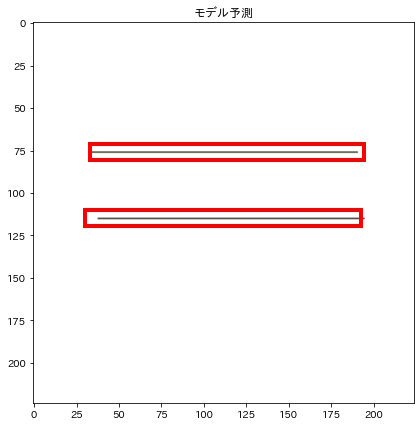

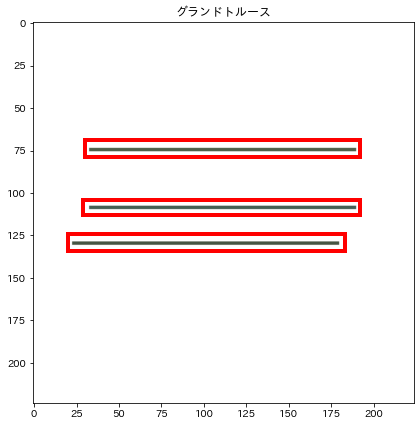

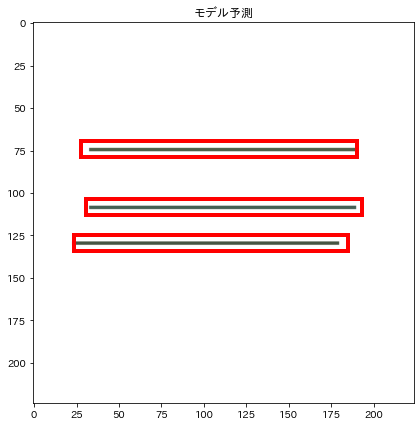

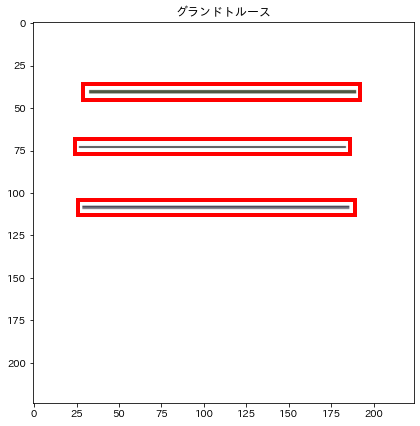

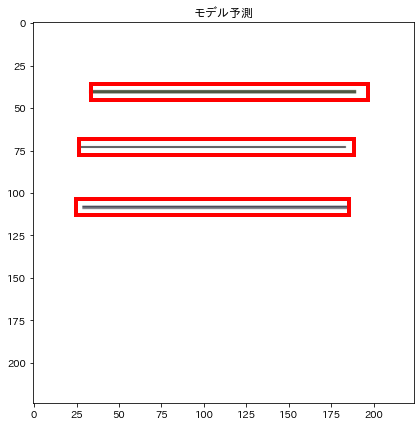

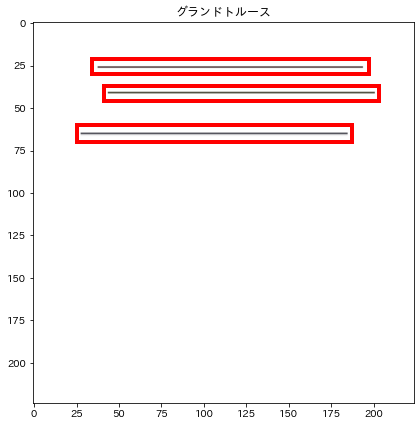

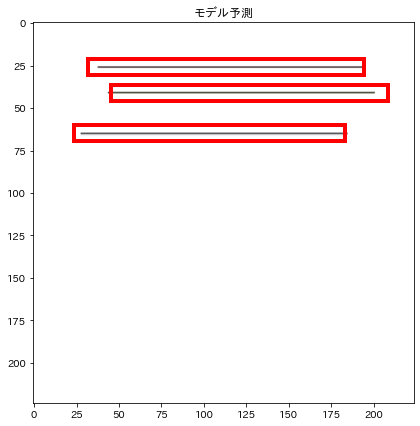

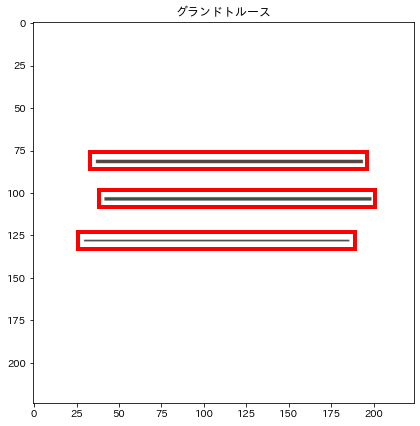

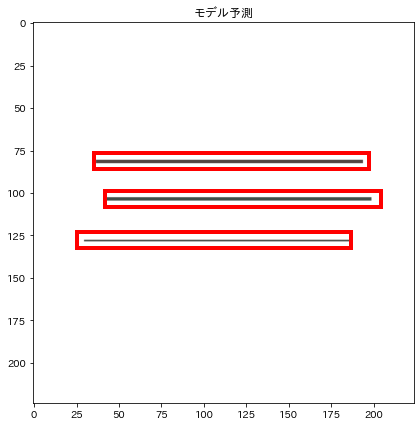

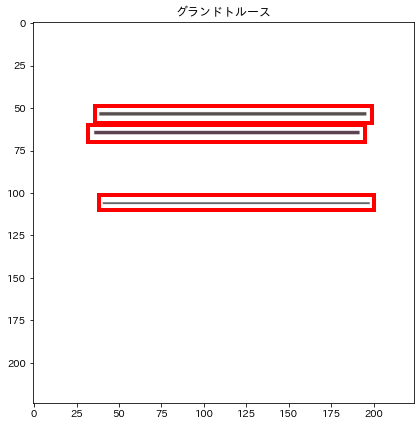

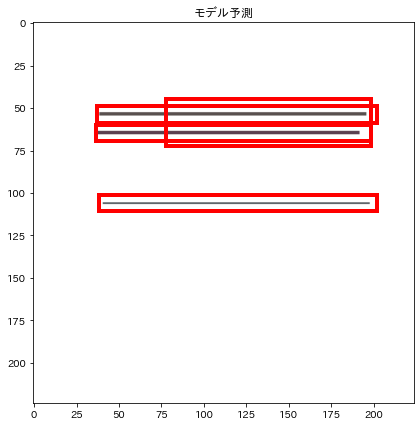

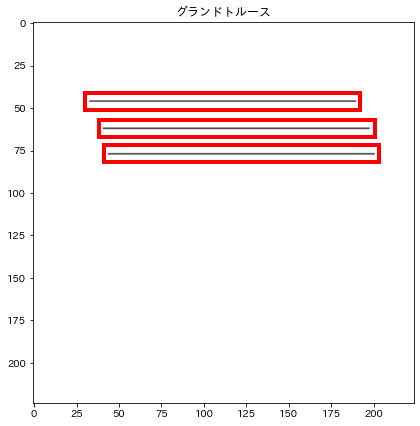

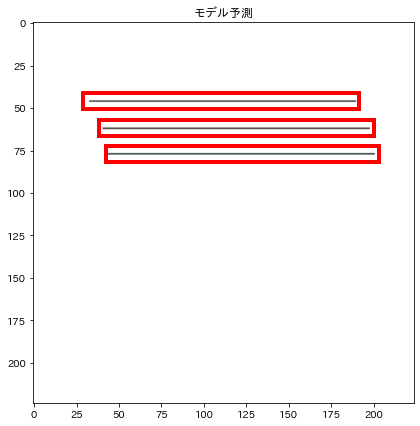

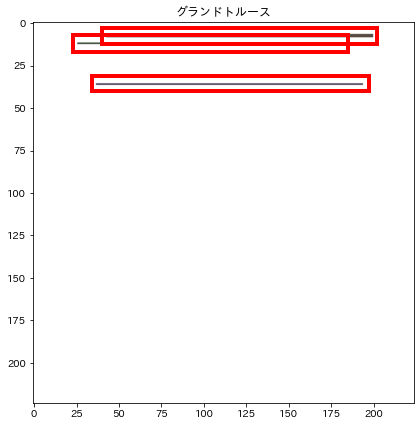

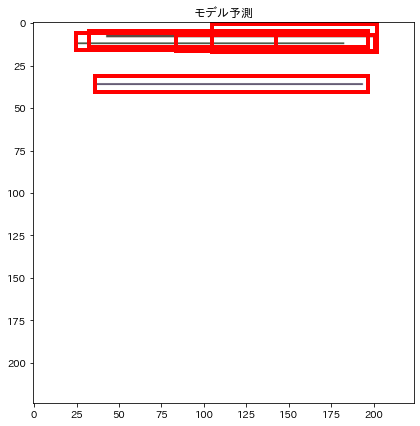

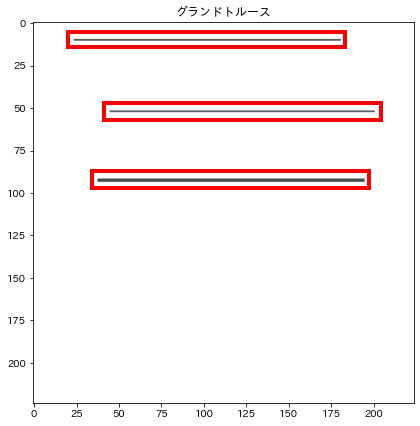

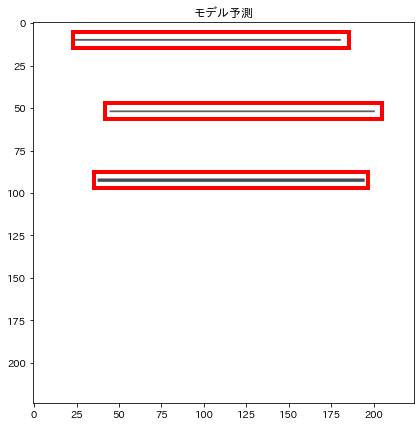

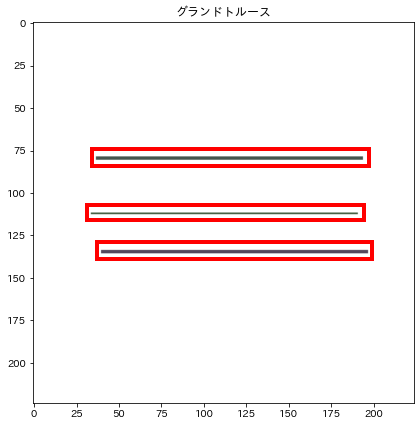

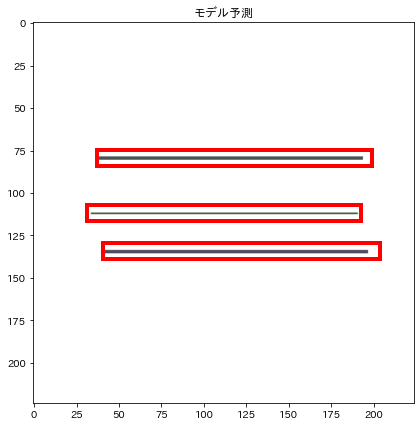

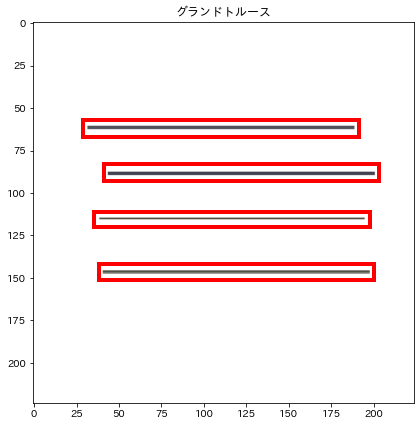

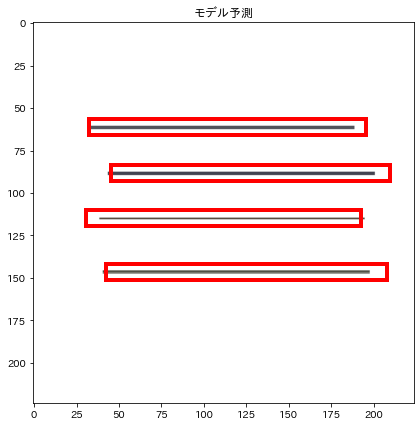

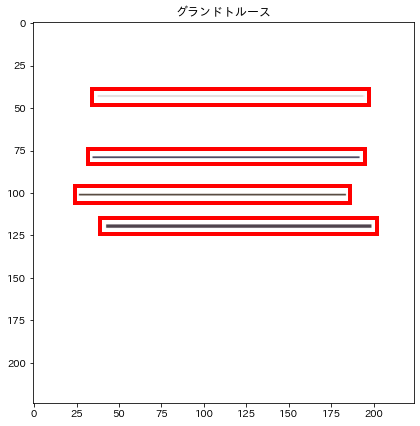

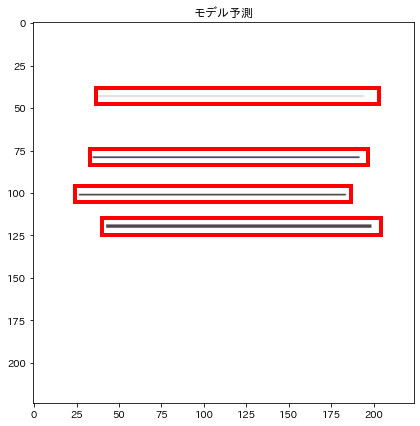

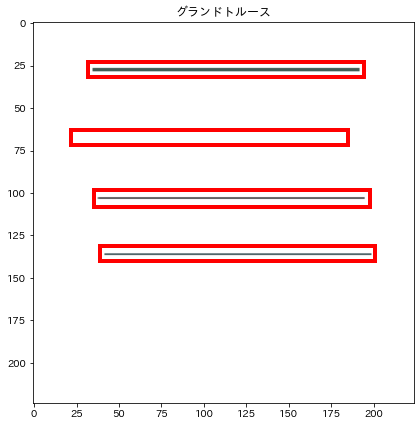

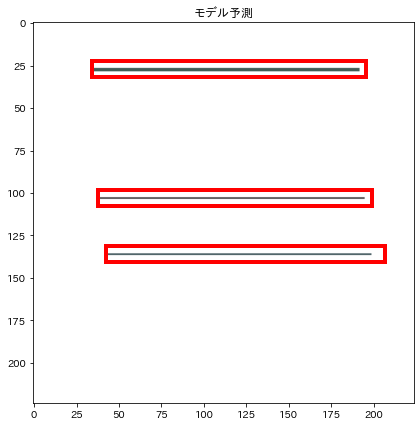

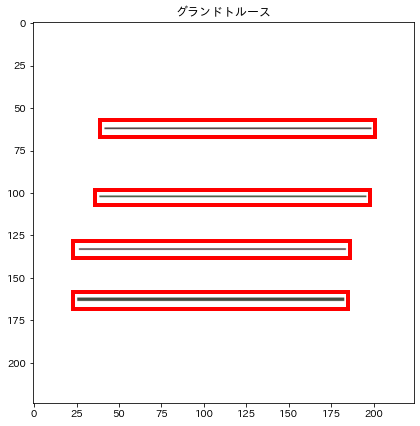

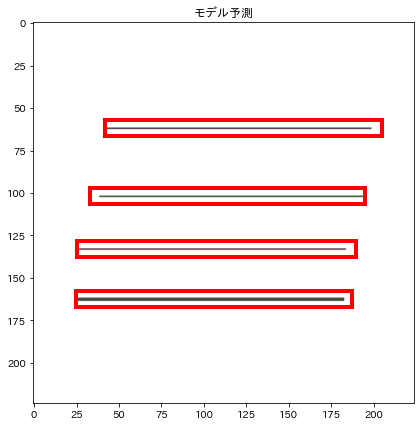

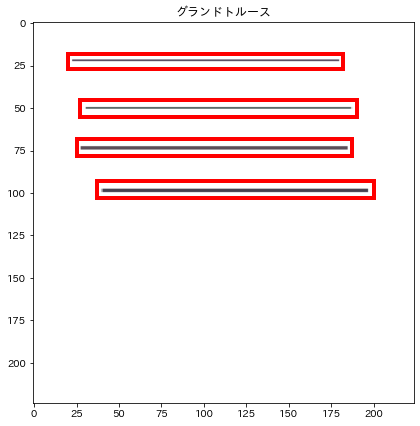

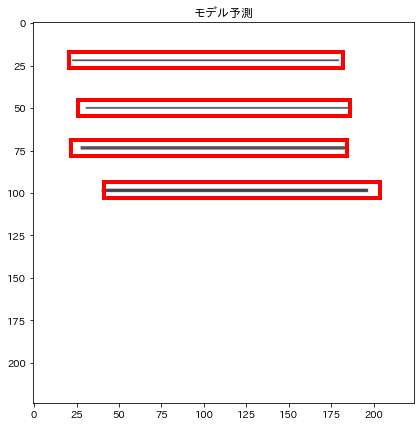

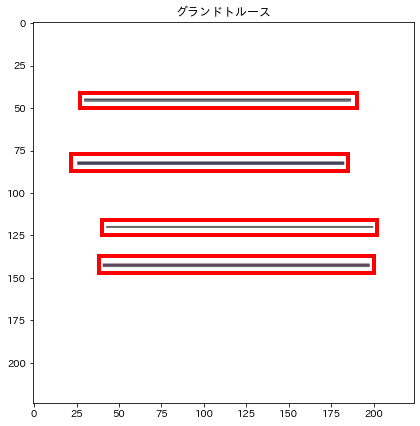

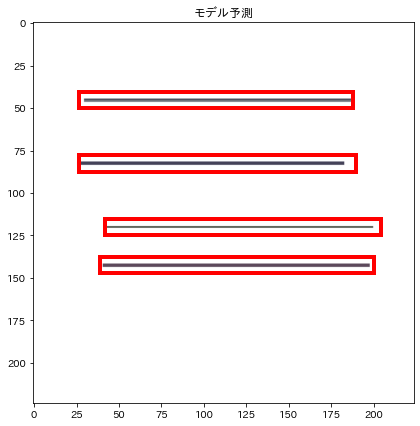

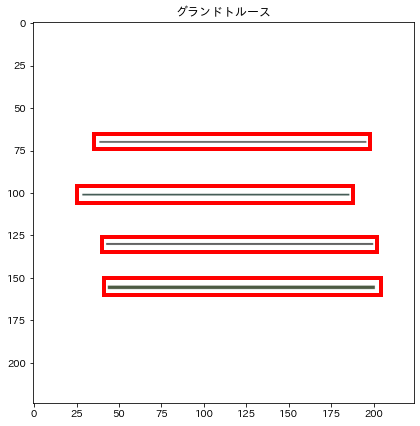

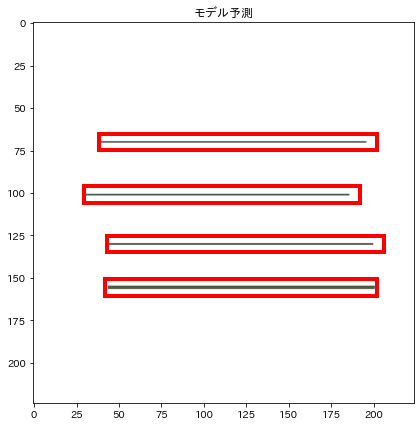

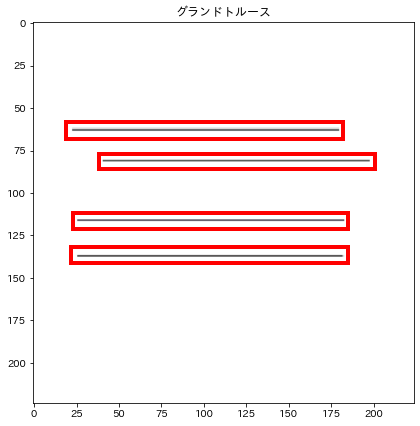

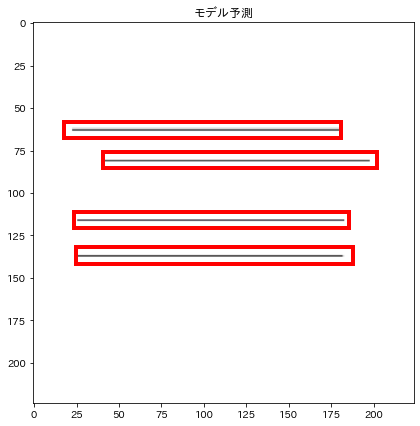

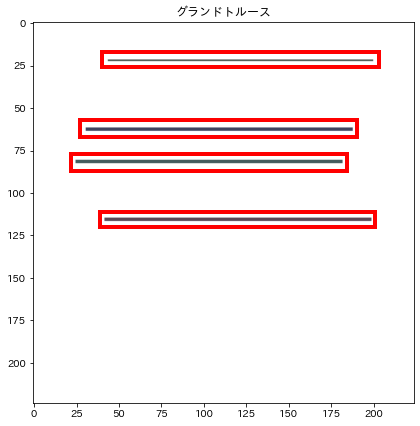

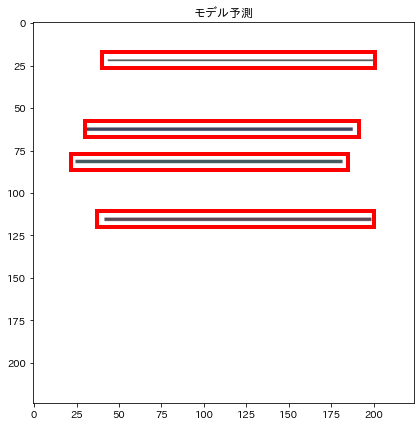

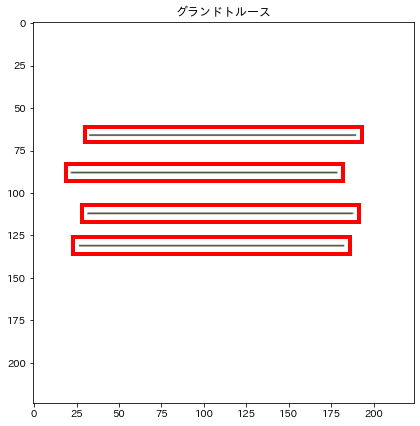

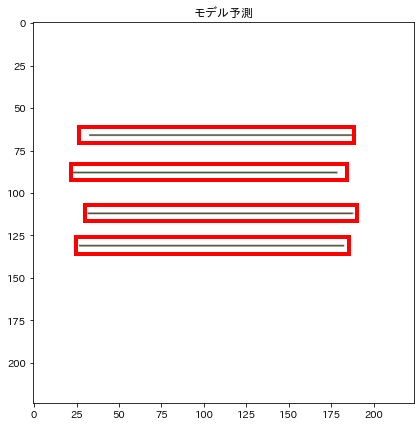

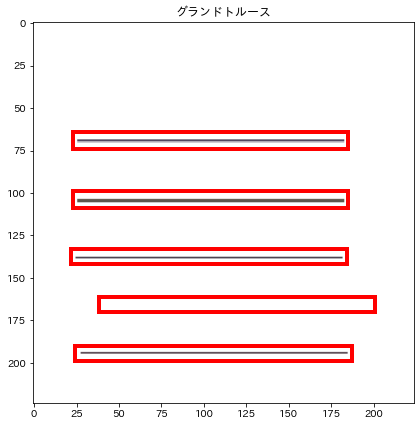

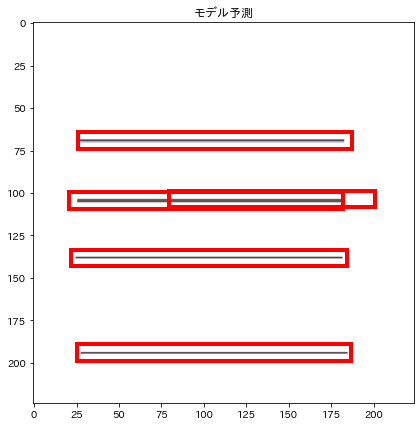

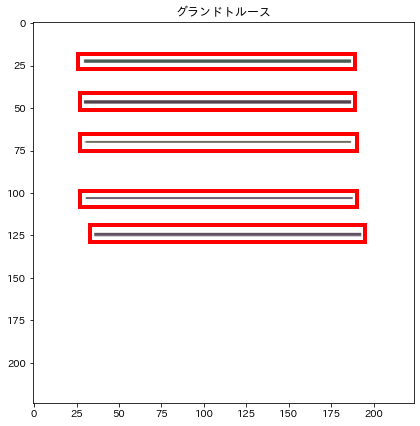

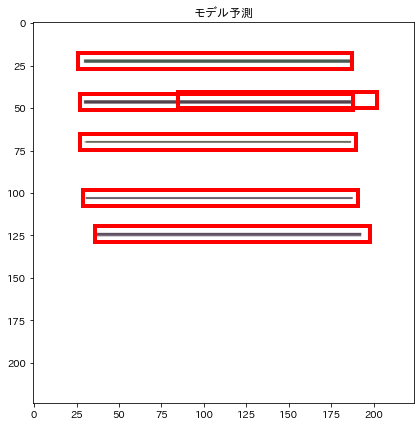

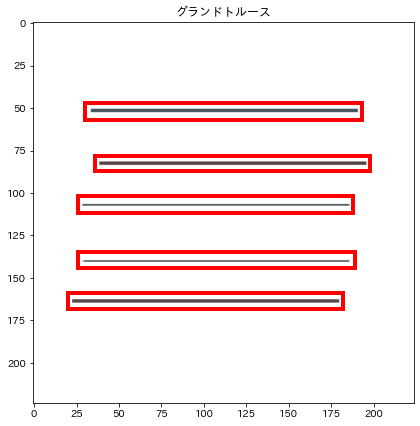

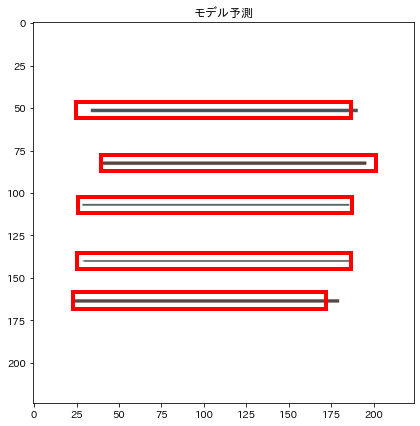

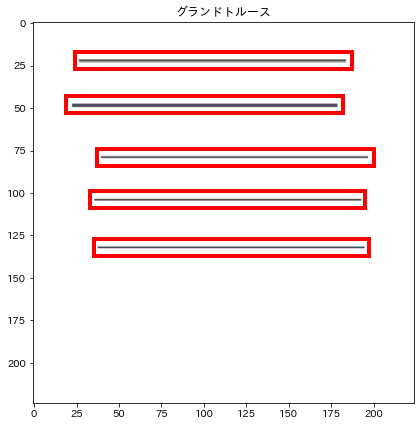

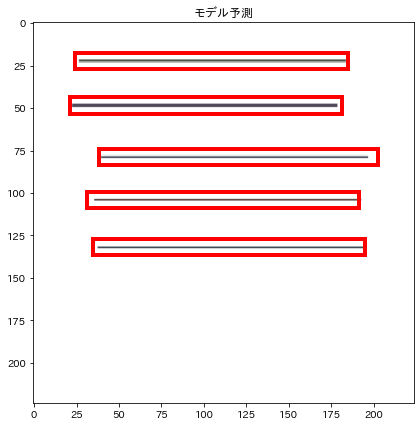

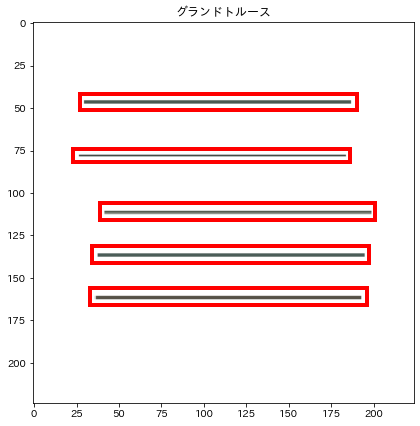

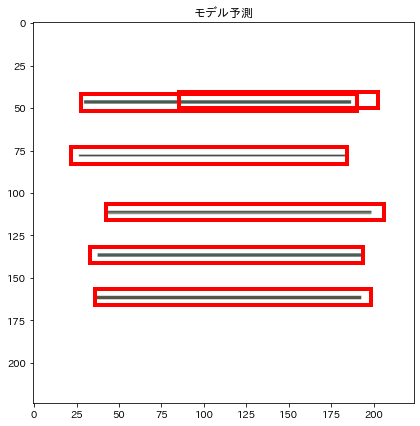

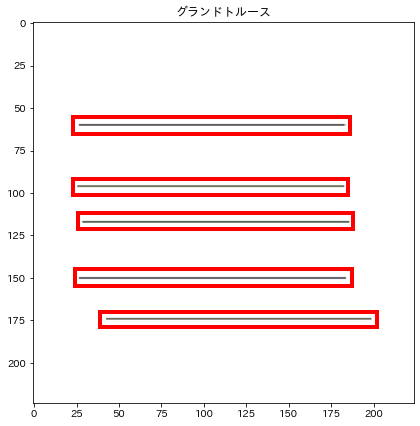

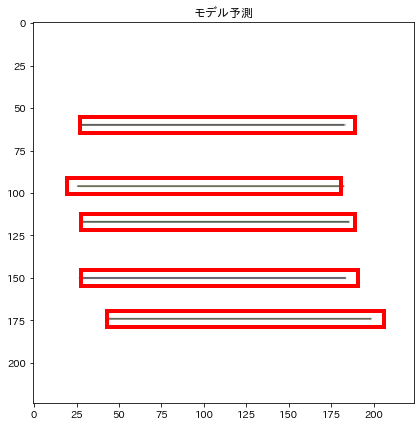

In [ ]:
from bit import plot_img_bbox

_dataset = test_dataset
for N in range(_dataset.__len__()):
    #N = np.random.choice(len(_dataset)) # テストセットから画像を 1 枚選ぶ
    img, target = _dataset[N]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    plot_img_bbox(torch_to_pil(img), target, title="グランドトルース")
    plot_img_bbox(torch_to_pil(img), prediction, title="モデル予測")